In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import tensorflow as tf
from collections import Counter

%matplotlib inline

In [21]:
# uncomment the group you want to train on
#race = "hispanic"
race = "white"
#race = "mixed"

In [22]:
X = np.load('../Data/' + race + '/X.npy')
Y2 = np.load('../Data/' + race + '/Y2.npy')

In [23]:
# shuffle
np.random.seed(42)
idx = np.random.permutation(len(X))
X = X[idx]
Y = Y2[idx]

#if race != 'hispanic':
#   X = X[:size_hispanic]
#    Y = Y[:size_hispanic]

TEST_SET_SIZE = int(0.1*len(Y))

X_train, X_test = X[:-TEST_SET_SIZE], X[-TEST_SET_SIZE:]
Y_train, Y_test = Y[:-TEST_SET_SIZE].astype(int), Y[-TEST_SET_SIZE:].astype(int)

In [24]:
# Features Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
std_scaler = StandardScaler()
X_train[:,-4:] = std_scaler.fit_transform(X_train[:,-4:])
X_test[:,-4:] = std_scaler.transform(X_test[:,-4:])

mm_scaler = MinMaxScaler(feature_range=(0,1))
X_train[:,:-4] = mm_scaler.fit_transform(X_train[:,:-4])
X_test[:,:-4] = mm_scaler.transform(X_test[:,:-4])

/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [25]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

def results(classifier,X_test=X_test, Y_test=Y_test):
    Y_pred_test = classifier.predict(X_test)
    #Y_pred_test = (Y_pred_test>=threshold).astype(int)
    print("Test accuracy score: " + str(accuracy_score(Y_test.astype(int), Y_pred_test)))
    print("ROC: " + str(roc_auc_score(Y_test, classifier.predict_proba(X_test)[:,1])))
    matrix = confusion_matrix(Y_test.astype(int), Y_pred_test)
    tn, fp, fn, tp = matrix.ravel()
    ppv = tp/(tp+fp)
    npv = tn/(tn+fn)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    g_mean = np.sqrt(sensitivity*specificity)
    #print("PPV: " + str(ppv))
    #print("NPV: " + str(npv))
    #print("Sensitivity: " + str(sensitivity))
    #print("Specificity: " + str(specificity))
    print("G-Mean: " + str(g_mean))
    #print("Confusion matrix:\n" + str(matrix))

## Autoencoder

In [68]:
from keras.layers import Input, Dense
from keras.models import Model

input_dim = X_train.shape[1]
encoding_dim = 150
hidden_dim1 = 250

input_vec = Input(shape=(input_dim,))
hidden1 = Dense(hidden_dim1, activation='relu')(input_vec)
encoded = Dense(encoding_dim, activation='relu')(hidden1)
hidden2 = Dense(hidden_dim1, activation='relu')(encoded)
decoded = Dense(input_dim, activation='tanh')(hidden2)

autoencoder = Model(input_vec, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X,X,epochs=7,batch_size=250)

Epoch 1/7
37575/37575 [==============================] - 2s 65us/step - loss: 0.1134
Epoch 2/7
37575/37575 [==============================] - 2s 53us/step - loss: 0.0442
Epoch 3/7
37575/37575 [==============================] - 2s 52us/step - loss: 0.0334
Epoch 4/7
37575/37575 [==============================] - 2s 53us/step - loss: 0.0297
Epoch 5/7
37575/37575 [==============================] - 2s 52us/step - loss: 0.0064
Epoch 6/7
37575/37575 [==============================] - 2s 52us/step - loss: -0.0061
Epoch 7/7
37575/37575 [==============================] - 2s 52us/step - loss: 0.0383


In [70]:
encoder = Model(input_vec, encoded)
X_train_enc = encoder.predict(X_train)
X_test_enc = encoder.predict(X_test)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

print('Logistic Regression')
lr = LogisticRegression(C=1)
lr.fit(X_train_enc, Y_train)
results(lr, X_test=X_test_enc, Y_test=Y_test)
print()
print('Random Forest')
rf_clf = RandomForestClassifier(n_estimators=20, min_samples_leaf=150, random_state=42)
rf_clf.fit(X_train_enc, Y_train)
results(rf_clf, X_test=X_test_enc, Y_test=Y_test)
print()
print('AdaBoost')
ab_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, 
                           algorithm="SAMME.R", learning_rate=1)
ab_clf.fit(X_train_enc, Y_train)
results(ab_clf, X_test=X_test_enc, Y_test=Y_test)

Logistic Regression


NameError: name 'X_train_enc' is not defined

## PCA

In [35]:
from sklearn.decomposition import PCA


for components in [150,200,250,300]:
    pca = PCA(n_components=components)
    X_train_red = pca.fit_transform(X_train)
    X_test_red = pca.transform(X_test)
    '''
    print('Logistic Regression')
    lr = LogisticRegression(C=1)
    lr.fit(X_train_red, Y_train)
    results(lr, X_test=X_test_red, Y_test=Y_test)
    print()
    print('Random Forest')
    rf_clf = RandomForestClassifier(n_estimators=20, min_samples_leaf=150, random_state=42)
    rf_clf.fit(X_train_red, Y_train)
    results(rf_clf, X_test=X_test_red, Y_test=Y_test)
    print()
    '''

    print('AdaBoost')
    ab_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, 
                               algorithm="SAMME.R", learning_rate=1)
    ab_clf.fit(X_train_red, Y_train)
    results(ab_clf, X_test=X_test_red, Y_test=Y_test)

AdaBoost
Test accuracy score: 0.8476083327284605
ROC: 0.8677417300294787
G-Mean: 0.6648894589926323
AdaBoost
Test accuracy score: 0.8491689046962329
ROC: 0.8670401541886152
G-Mean: 0.6685818947250881
AdaBoost
Test accuracy score: 0.8495318284096682
ROC: 0.8675604294930589
G-Mean: 0.6694331267833511
AdaBoost
Test accuracy score: 0.8487696886114539
ROC: 0.8666418779846885
G-Mean: 0.6705880549278442


In [99]:
pca = PCA(n_components=X.shape[1])
pca.fit(X)
variance_captured = []
for components in range(0,X.shape[1], 5):
    variance_captured.append([components,sum(pca.explained_variance_ratio_[:components])])
variance_captured_np = np.array(variance_captured)

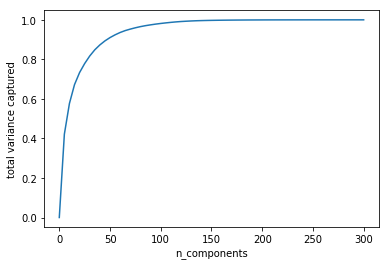

In [105]:
plt.plot(variance_captured_np[:,0], variance_captured_np[:,1])
plt.xlabel('n_components')
plt.ylabel('total variance captured')
plt.show()